In [1]:
from os import listdir
from os.path import isfile, join
import re
import csv
import gensim
import numpy as np
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.models.wrappers import FastText
import logging
import os
import pandas as pd 
import sys
import sklearn.metrics
import sklearn
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import random
import math
import warnings
import utils
from utils import *
from utils2 import *
import scipy.stats
from dataDictionariesLexicons import *
from testData import *
from polesConstructs import *

random.seed(1)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
# warnings.filterwarnings('ignore')

sys.path.insert(0, '../') # necessary in order to import word2vecTraining where the epoch saver class, which is part of the model, is located

In [2]:
modelsPath = os.path.normpath(r'D:\data\wordVectors') 
# modelFilePath = os.path.join(modelsPath, 'GoogleNews-vectors-negative300.bin')
# model2 = KeyedVectors.load_word2vec_format(modelFilePath,binary=True) 
modelFilePath = os.path.join(modelsPath, 'GoogleNews-vectors-negative300LowerCase.bin')
model1 = KeyedVectors.load(modelFilePath) 

In [3]:
modelsPath = os.path.normpath(r'D:\data\wordVectors') 
modelFilePath = os.path.join(modelsPath, 'glove.6B.300d.txt.word2vec.bin')
model2 = KeyedVectors.load_word2vec_format(modelFilePath,binary=True) 

In [4]:
modelsPath = os.path.normpath(r'D:\data\wordVectors') 
modelFilePath = os.path.join(modelsPath, 'glove.twitter.27B.200d.txt.word2vec.bin')
model3 = KeyedVectors.load(modelFilePath) 

In [5]:
modelsPath = os.path.normpath(r'D:\data\wordVectors') 
modelFilePath = os.path.join(modelsPath, 'glove.42B.300d.txt.word2vec.bin')
model4 = KeyedVectors.load(modelFilePath) 

In [6]:
modelsPath = os.path.normpath(r'D:\data\wordVectors') 
modelFilePath = os.path.join(modelsPath, 'glove.840B.300d.txt.word2vec.bin')
model5 = KeyedVectors.load(modelFilePath) 

In [7]:
modelsPath = os.path.normpath(r'D:\data\wordVectors') 
modelFilePath = os.path.join(modelsPath, 'fastext-common-crawl-300d-2M-subword.bin')
model6 = KeyedVectors.load(modelFilePath)

In [8]:
modelsPath = os.path.normpath(r'D:\data\wordVectors') 
modelFilePath = os.path.join(modelsPath, 'fastext-wiki-news-300d-1M-subword-Original.bin')
model7 = KeyedVectors.load(modelFilePath)

In [9]:
# models = [model1,model2,model3,model4]
# models = [model1,model2]
models = [model1,model2,model3,model4,model5,model6,model7]
# models = [model1]

In [10]:
#change default lexicons
# lexicons = [harvardGeneralInquirer3623, vaderLexicon7062,NRCEmotionLexicon5555,opinionLexicon6786,afinnLexicon2477]
# lexicons = [WEAT1]
lexicons = [harvardGeneralInquirer3623]
dataDict = dataDictLoadLexicons(dataDict,lexicons)
# WEAT1 harvardGeneralInquirer3623

In [11]:
dataSetIndexes = [
# '0-1', #percentage females per occupation
# '0-2', #country's GDP per capita
# '0-3', #car brands and prices
# '0-4', #voting behavior by ethnic/racial group
# '0-5', #voting behavior by profession
    
'1-1', #gender
'1-2',
'1-3',
'1-4',
'1-5',
    
'2-1', #Race/ethnicity
'2-2',
'2-3',
'2-4',    
  
'3-1', #Sexual orientation  
    
'4-1', #religiosity    
'4-2', #religion Islam and Christianity
    
'5-1', #age 
'6-1', #socioeconomic status
'7-1', #physical beauty
    
'8-1', #Personal ideology
'8-2', #Party affiliation and political parties
'8-3', #US presidents
'8-4', #Ideologies abstract
'8-5', #influential conservatives and liberals
]

In [12]:
rows = len(dataSetIndexes)
columns = len(models)
outputMatrix = np.zeros((rows,columns))
outputMatrixPvalues = np.zeros((rows,columns))

## Dimensions against models

In [13]:
#Checking for the existence of uppercase letters in models
# [w for w in model7.wv.vocab if any(x.isupper() for x in w)]

In [14]:
#Checking for the existence _ in models
# [w for w in model2.wv.vocab if '-' in w]

In [15]:
for rowNumber, dataSetIndex in enumerate(dataSetIndexes):
    print(dataDict[dataSetIndex]['name'])
    modelsCorrelations=[]
    modelspvalues=[]
    for i,model in enumerate(models):    
#         print("model", i+1)
        correlations = []
        pvalues = []
        constructPole1 = dataDict[dataSetIndex]['constructPole1']
        constructPole2 = dataDict[dataSetIndex]['constructPole2']
        
        if i>=1: #Glove and fastext vocabulary uses - instead of _ So we need to alter Construct poles and real data - Checked!
            constructPole1,constructPole2,RealDataTemp=replaceUnderscoreForDash(constructPole1,constructPole2,RealDataTemp)
        if i in [1,2,3]: # Lowercase poles for models With only lowercase vocabularies - remove duplicates - Checked!
            constructPole1 = list(set(list(map(str.lower,constructPole1))))
            constructPole2 = list(set(list(map(str.lower,constructPole2))))
        constructPole1,constructPole2 = constructsFilter(model,constructPole1,constructPole2,printFlag=False)# Filter out terms not in model vocabulary
        
        for RealDataTemp in dataDict[dataSetIndex]['RealDataLexicons']:
#         for RealDataTemp in [voteByEthnicity]:
            RealData = realDataFilter(model,RealDataTemp,0)#Filter out terms not in model vocabulary (Last parameter Flag prints out OOV words)
            Axis = dimensionN(model, constructPole1,constructPole2)  
            AxisName='Axis'
            try:
                dataFrame = makeDF(model, RealData.keys(),Axis,AxisName)
            except:
                continue
            dataFrame['RealValues']=RealData.values()
            spearmanCorr,pearsonCorr=calculateCorrelations(dataFrame,printFlag=False)
#             correlations.append(pearsonCorr[0])
#             pvalues.append(pearsonCorr[1])
            correlations.append(spearmanCorr[0])
            pvalues.append(spearmanCorr[1])            
#         print("correlations for model", i+1)
#         print(*correlations)
#         print("mean: ", np.array(correlations).mean())
        modelsCorrelations.append(np.array(correlations).mean())
        modelspvalues.append(np.array(pvalues).mean())#This can only be done if only one lexicon is being tested
#         print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")
    print(*modelsCorrelations)
    print(np.array(modelsCorrelations).mean())
    outputMatrix[rowNumber]=modelsCorrelations
    outputMatrixPvalues[rowNumber]=modelspvalues
    #Print closest neighbors to axis Poles
#     print([w[0] for w in model.wv.similar_by_vector(-Axis,restrict_vocab=50000,topn=50)])
#     print([w[0] for w in model.wv.similar_by_vector(Axis,restrict_vocab=50000,topn=50)])

    print("XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX")

gender general
0.20438396461860675 0.1666695711247343 0.04745237710444724 0.27708462261524563 0.20931930649506927 0.2525995097241693 0.14772310867051805
0.18646178005039862
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
gender family roles
0.023192915019752524 0.10098246575726705 0.02054445286963377 0.11835789238191557 0.09468268184316794 0.2126214057155342 0.06939902360015776
0.09139726245534699
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
gender and young age
0.10788435045954331 0.1181680237172067 0.05741047682862865 0.20577376678618597 0.17691431273215272 0.1883581179994758 0.17112579516652687
0.14651926338424573
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
gender masculinity and femininity
0.2373733719609817 0.24951690530340281 0.029122093049238705 0.3323625671516852 0.2718485687185625 0.16959290729524767 0.0799924208074061
0.1956869763266464
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
gender and popular given names 
0.027523759016165696 -0.10312897638332744 

In [16]:
#print output matrix
for r in outputMatrix:
    print(*r)

0.20438396461860675 0.1666695711247343 0.04745237710444724 0.27708462261524563 0.20931930649506927 0.2525995097241693 0.14772310867051805
0.023192915019752524 0.10098246575726705 0.02054445286963377 0.11835789238191557 0.09468268184316794 0.2126214057155342 0.06939902360015776
0.10788435045954331 0.1181680237172067 0.05741047682862865 0.20577376678618597 0.17691431273215272 0.1883581179994758 0.17112579516652687
0.2373733719609817 0.24951690530340281 0.029122093049238705 0.3323625671516852 0.2718485687185625 0.16959290729524767 0.0799924208074061
0.027523759016165696 -0.10312897638332744 -0.009700006426794413 -0.0008054645798427222 0.000421426759612671 0.2491775586953478 0.01620531501503549
-0.2645845709929907 0.03910012188113457 -0.005452786901373402 -0.06321080917566786 -0.0783965939697716 0.07185643391667844 0.0670895549949331
-0.08739011101160567 -0.16147170645279044 -0.07472593351055895 -0.2051888969487007 -0.23408573994211657 -0.1919087258454495 -0.023736353643417984
-0.040675383

In [17]:
#print P values output matrix
for r in outputMatrixPvalues:
    print(*r)

2.609597806337869e-35 8.283563416802e-24 0.00494326342707489 1.1909706698955156e-64 4.876161916573479e-37 1.0812192317591212e-53 4.6475612198301925e-19
0.16378965599999926 1.2939216693076294e-09 0.22385707175385847 9.682700073996909e-13 1.1947513869013198e-08 3.37669446919526e-38 3.0097119793488792e-05
8.293898494025836e-11 1.180725455553013e-12 0.0006703236139930866 7.956069139643043e-36 8.942764556148741e-27 3.3708333911118294e-30 4.0443684975839228e-25
2.283666279060523e-47 3.7366278776024774e-52 0.08464302059483893 7.335967386359659e-94 3.3124990486596215e-62 1.0299228841110107e-24 1.4973584199931225e-06
0.09842427751957535 5.725024951997092e-10 0.5658037660690864 0.9614094908943162 0.9798033583119372 2.993711147071612e-52 0.33042399711353954
7.969614731716808e-59 0.019054716796487833 0.7468460024968192 0.0001441571478255045 2.398117159285863e-06 1.541596670082419e-05 5.494035823868317e-05
1.472121240758174e-07 1.991967557294789e-22 9.428499069720832e-06 1.2548419359739314e-35 3.86

## adjusting P values for multiple tests

In [18]:
outputMatrixPvalues.shape

(20, 7)

In [19]:
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector

stats = importr('stats')

#bonferroni most conservative, holm also valid under arbitrary assumptions
p_adjust = stats.p_adjust(FloatVector(outputMatrixPvalues.flatten()), method = 'bonferroni')
outputMatrixPvaluesCorrected = np.array(p_adjust).reshape(outputMatrixPvalues.shape)

In [20]:
#print P values output matrix
for r in outputMatrixPvaluesCorrected:
    print(*r)

3.6534369288730164e-33 1.1596988783522801e-21 0.6920568797904846 1.6673589378537218e-62 6.826626683202871e-35 1.5137069244627695e-51 6.506585707762269e-17
1.0 1.8114903370306812e-07 1.0 1.3555780103595673e-10 1.6726519416618478e-06 4.727372256873364e-36 0.004213596771088431
1.161145789163617e-08 1.6530156377742184e-10 0.09384530595903214 1.113849679550026e-33 1.2519870378608237e-24 4.719166747556561e-28 5.662115896617492e-23
3.1971327906847326e-45 5.231279028643469e-50 1.0 1.0270354340903522e-91 4.63749866812347e-60 1.441892037755415e-22 0.00020963017879903716
1.0 8.01503493279593e-08 1.0 1.0 1.0 4.1911956059002568e-50 1.0
1.115746062440353e-56 1.0 1.0 0.02018200069557063 0.0003357364023000208 0.002158235338115387 0.007691650153415643
2.0609697370614437e-05 2.7887545802127045e-20 0.0013199898697609164 1.756778710363504e-33 5.415828738966651e-44 3.6962969360072087e-29 1.0
1.0 1.0 1.0 1.0 1.0 1.299780116197019e-12 4.097359723532477e-24
0.052705109802930576 2.1908758058407626e-05 1.0 0.06

## Correlation of results between different models

In [21]:
#Calculating correlation of measurements across models
df = pd.DataFrame(outputMatrix)
df.iloc[:, 0].corr(df.iloc[:, 6])

0.7897952367749574

In [22]:
df.corr()

,0,1,2,3,4,5,6
0,1.000000,0.705329,0.587842,0.785237,0.836033,0.802737,0.789795
1,0.705329,1.000000,0.772159,0.941926,0.886963,0.692568,0.695451
2,0.587842,0.772159,1.000000,0.766606,0.793544,0.606868,0.594921
3,0.785237,0.941926,0.766606,1.000000,0.965017,0.737210,0.713912
4,0.836033,0.886963,0.793544,0.965017,1.000000,0.816276,0.799086
5,0.802737,0.692568,0.606868,0.737210,0.816276,1.000000,0.908814
6,0.789795,0.695451,0.594921,0.713912,0.799086,0.908814,1.000000


In [23]:
#average of all correlations above the main diagonal
correlationMatrix = np.array(df.corr())
allPairwiseCorrelations = correlationMatrix[np.triu_indices(7,k=1)] #If you want to extract the values that are above the diagonal (or below) then use the k argument.
allPairwiseCorrelations.mean()

0.7713473039750887

## Figure

In [24]:
axisNames=[]
constructPole1List=[]
constructPole2List=[]

for key in dataSetIndexes:
    if key=='2-1':
        axisNames.append(dataDict[key]['name'])
        constructPole1List.append(['Whites','White_American'])
        constructPole2List.append(['Blacks','African_American'])
    elif key=='2-2':
        axisNames.append(dataDict[key]['name'])
        constructPole1List.append(['Adam','Chip'])
        constructPole2List.append(['Tyrone','Latisha'])
    elif key=='2-3':
        axisNames.append(dataDict[key]['name'])
        constructPole1List.append(['Whites','White_American'])
        constructPole2List.append(['Hispanics','Hispanic_American'])
    elif key=='2-4':
        axisNames.append(dataDict[key]['name'])
        constructPole1List.append(['Whites','White_American'])
        constructPole2List.append(['Asians','Asian_American'])
    elif key=='1-2':
        axisNames.append(dataDict[key]['name'])
        constructPole1List.append(['father','husband'])
        constructPole2List.append(['mother','wife'])
    elif key=='3-1':
        axisNames.append(dataDict[key]['name'])
        constructPole1List.append(['heterosexual','heterosexuality'])
        constructPole2List.append(['homosexual','homosexuality'])
    elif key=='4-1':
        axisNames.append(dataDict[key]['name'])
        constructPole1List.append(['Christian','Muslim'])
        constructPole2List.append(['atheist','nonreligious'])
    elif key=='5-1':
        axisNames.append(dataDict[key]['name'])
        constructPole1List.append(['senior_citizens','elders'])
        constructPole2List.append(dataDict[key]['constructPole2'][:2])
    elif key=='6-1':
        axisNames.append(dataDict[key]['name'])
        constructPole1List.append(['working_class','middle_class'])
        constructPole2List.append(['upper_class','rich'])
    elif key=='7-1':
        axisNames.append(dataDict[key]['name'])
        constructPole1List.append(['unattractive','plain_looking'])
        constructPole2List.append(['beautiful','handsome'])
    elif key=='8-1':
        axisNames.append(dataDict[key]['name'])
        constructPole1List.append(dataDict[key]['constructPole1'][:2])        
        constructPole2List.append(dataDict[key]['constructPole2'][:2])        
    elif key=='8-2':
        axisNames.append(dataDict[key]['name'])
        constructPole1List.append(['Republicans','Republican_Party'])
        constructPole2List.append(['Democrats','Democratic_Party'])
    elif key=='8-3':
        axisNames.append(dataDict[key]['name'])
        constructPole1List.append(['Eisenhower','Bush'])
        constructPole2List.append(['Truman','Obama'])
    elif key=='8-4':
        axisNames.append(dataDict[key]['name'])
        constructPole1List.append(['conservatism','neoconservatism'])
        constructPole2List.append(['liberalism','progressivism'])        
    elif key=='8-5':
        axisNames.append(dataDict[key]['name'])
        constructPole1List.append(['Mitt_Romney','Dick_Cheney'])
        constructPole2List.append(['Hillary_Clinton','Al_Gore'])        
        
#     elif key=='7-4':
#         axisNames.append(dataDict[key]['name'])
#         constructPole1List.append(dataDict[key]['constructPole1'][:2])
#         constructPole2List.append(dataDict[key]['constructPole2'][:2])
#     elif key=='8-1':
#         axisNames.append(dataDict[key]['name'])
#         constructPole1List.append(dataDict[key]['constructPole1'][:2])
#         constructPole2List.append(dataDict[key]['constructPole2'][:2])
#     elif key=='8-2':
#         axisNames.append(dataDict[key]['name'])
#         constructPole1List.append(dataDict[key]['constructPole1'][:2])
#         constructPole2List.append(dataDict[key]['constructPole2'][:2])
#     elif key=='8-4':
#         axisNames.append(dataDict[key]['name'])
#         constructPole1List.append(dataDict[key]['constructPole1'][:2])
#         constructPole2List.append(dataDict[key]['constructPole2'][:2])
#     elif key=='8-5':
#         axisNames.append(dataDict[key]['name'])
#         constructPole1List.append(['nra','Fox news','Police'])
#         constructPole2List.append(['Single mothers','Immigrants'])
        
    else:
        axisNames.append(dataDict[key]['name'])
        constructPole1List.append(dataDict[key]['constructPole1'][:2])
        constructPole2List.append(dataDict[key]['constructPole2'][:2])
    

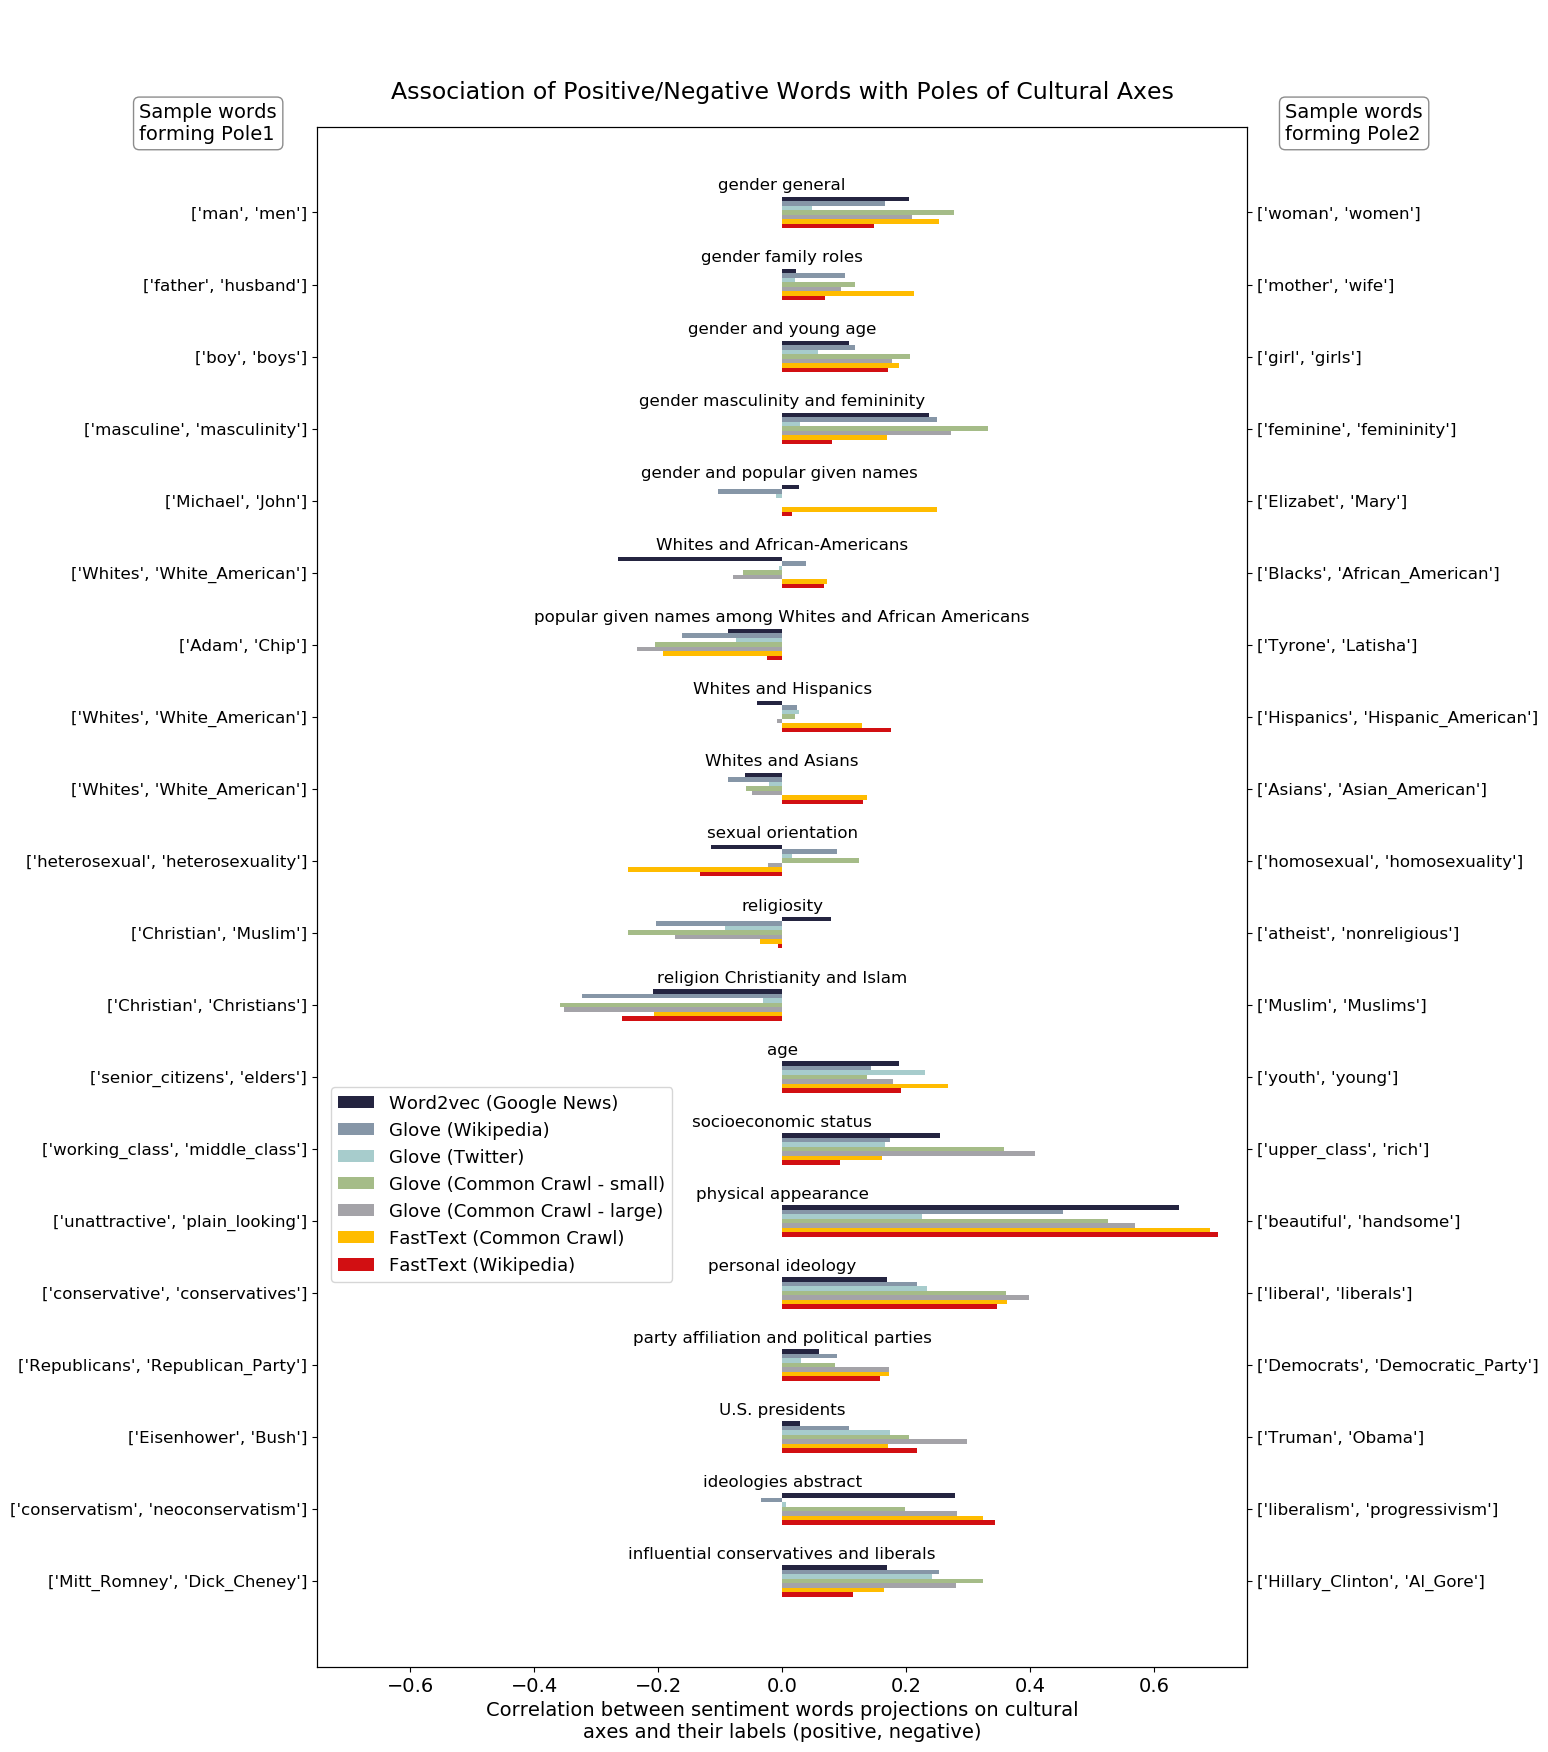

In [25]:
plt.rcdefaults()

fig, ax = plt.subplots()
fig.set_size_inches(12,20)

stepSize=16
y = np.arange(stepSize*len(axisNames),step=stepSize)
# y_pos = np.arange(len(axisNames),step=1)
correlationsWord2Vec = list(outputMatrix[:,0].flatten()) #only one model at a time
correlationsGloveWiki = list(outputMatrix[:,1].flatten()) #only one model at a time
correlationsGloveTwitter = list(outputMatrix[:,2].flatten()) #only one model at a time
correlationsGloveCommonCrawlSmall = list(outputMatrix[:,3].flatten()) #only one model at a time
correlationsGloveCommonCrawlLarge = list(outputMatrix[:,4].flatten()) #only one model at a time
correlationsFastTextCommonCrawl = list(outputMatrix[:,5].flatten()) #only one model at a time
correlationsFastTextWiki = list(outputMatrix[:,6].flatten()) #only one model at a time

#left Y axis
ax.set_yticks(y)
ax.set_yticklabels(constructPole1List,fontsize=12)
ax.invert_yaxis()  # labels read top-to-bottom

#right Y axis
ax2 = ax.twinx()
ax2.set_yticks(y)
ax2.set_yticklabels(constructPole2List,fontsize=12)
ax2.invert_yaxis()  # labels read top-to-bottom

barWidth = 1  # the width of the bars

#plot data left y axis. color palette https://tabithadumas.com/look-good-in-any-color/
ax.barh(y -3*barWidth, correlationsWord2Vec, barWidth, label='Word2vec (Google News)', color='#242440', align='center')
ax.barh(y -2*barWidth, correlationsGloveWiki, barWidth, label='Glove (Wikipedia)', color='#8696A7')
ax.barh(y -1*barWidth, correlationsGloveTwitter, barWidth, label='Glove (Twitter)', color='#A7CCCC', align='center')
ax.barh(y + 0*barWidth, correlationsGloveCommonCrawlSmall, barWidth, label='Glove (Common Crawl - small)', color='#A5BC88')
ax.barh(y + 1*barWidth, correlationsGloveCommonCrawlLarge, barWidth, label='Glove (Common Crawl - large)', color='#A4A3A8')
ax.barh(y + 2*barWidth, correlationsFastTextCommonCrawl, barWidth, label='FastText (Common Crawl)', color='#FFBC00', align='center')
ax.barh(y + 3*barWidth, correlationsFastTextWiki, barWidth, label='FastText (Wikipedia)', color='#D20F12')


#plot data right y axis. For proper alignment of Y axis labels. I'm just plotting 0 values so nothing gets visualized 
ax2.barh(y -3*barWidth, correlationsWord2Vec, barWidth, color='#0DBE98', align='center',alpha=0)
ax2.barh(y -2*barWidth, correlationsGloveWiki, barWidth, color='black',alpha=0)
ax2.barh(y -1*barWidth, correlationsGloveTwitter, barWidth, color='#2E6E9D', align='center',alpha=0)
ax2.barh(y + 0*barWidth, correlationsGloveCommonCrawlSmall, barWidth, color='#FF5500',alpha=0)
ax2.barh(y + 1*barWidth, correlationsGloveCommonCrawlLarge, barWidth, color='black',alpha=0)
ax2.barh(y + 2*barWidth, correlationsFastTextCommonCrawl, barWidth, color='#2E6E9D', align='center',alpha=0)
ax2.barh(y + 3*barWidth, correlationsFastTextWiki, barWidth, color='#FF5500',alpha=0)

ax.set_xlabel('Correlation between sentiment words projections on cultural\naxes and their labels (positive, negative)',fontsize=14)
# ax.set_xlim(-0.5,0.5)
#ax.set_title('Associations of Negative and Positive Sentiment\nWords with Poles of Cultural Axes',pad=20,fontsize=18)
ax.set_title('Association of Positive/Negative Words with Poles of Cultural Axes',pad=20,fontsize=17)

for yp,dataSetIndex in zip(y,dataSetIndexes):
    axis=dataDict[dataSetIndex]['name']
    ax.text(0,yp-5,axis, horizontalalignment='center',fontsize=12)

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax.annotate('Sample words\nforming Pole1',xy=(0.09, 0.92), bbox=bbox_props,
            xycoords='figure fraction',fontsize=14)
ax.annotate('Sample words\nforming Pole2',xy=(0.83, 0.92), bbox=bbox_props,
            xycoords='figure fraction',fontsize=14)

ax.xaxis.set_tick_params(labelsize=14)

# ax.legend(loc='center right',fontsize=14,ncol=1)
ax.legend(loc=(0.015,0.25),fontsize=13,ncol=1)
plt.xlim([-0.75,0.75])
plt.savefig('../../paper/figures/correlationsModelsAgainsConstructsWithoutSignificanceAnnotation.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()

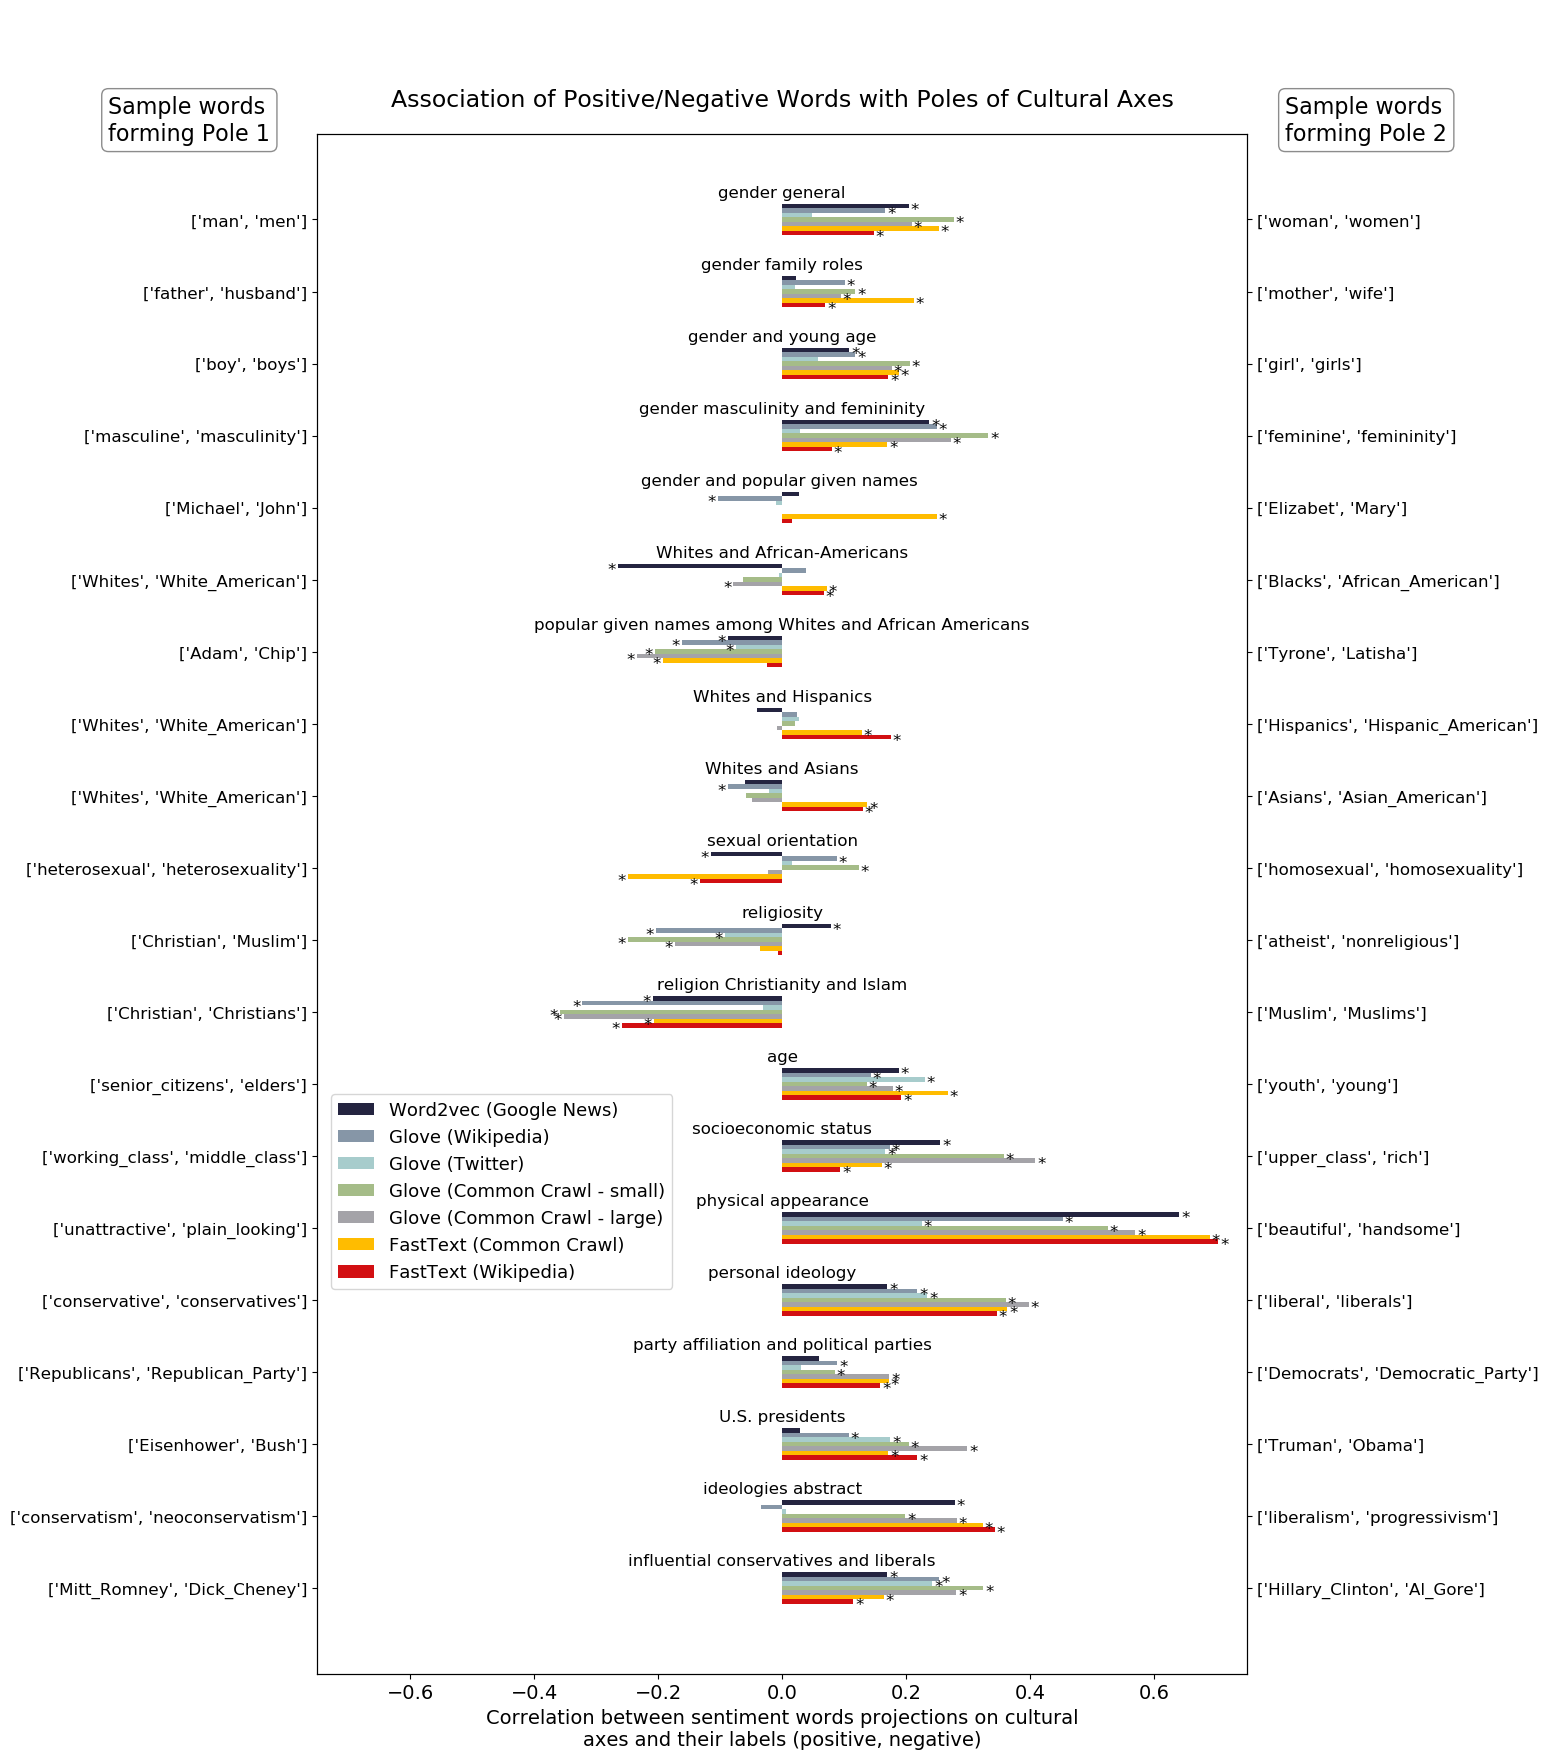

In [26]:
plt.rcdefaults()

fig, ax = plt.subplots()
fig.set_size_inches(12,20)

stepSize=16
y = np.arange(stepSize*len(axisNames),step=stepSize)
# y_pos = np.arange(len(axisNames),step=1)
correlationsWord2Vec = list(outputMatrix[:,0].flatten()) #only one model at a time
correctedPvaluesWord2Vec = list(outputMatrixPvaluesCorrected[:,0].flatten())

correlationsGloveWiki = list(outputMatrix[:,1].flatten()) #only one model at a time
correctedPvaluesGloveWiki = list(outputMatrixPvaluesCorrected[:,1].flatten())

correlationsGloveTwitter = list(outputMatrix[:,2].flatten()) #only one model at a time
correctedPvaluesGloveTwitter = list(outputMatrixPvaluesCorrected[:,2].flatten())

correlationsGloveCommonCrawlSmall = list(outputMatrix[:,3].flatten()) #only one model at a time
correctedPvaluesGloveCommonCrawlSmall = list(outputMatrixPvaluesCorrected[:,3].flatten())

correlationsGloveCommonCrawlLarge = list(outputMatrix[:,4].flatten()) #only one model at a time
correctedPvaluesGloveCommonCrawlLarge = list(outputMatrixPvaluesCorrected[:,4].flatten())

correlationsFastTextCommonCrawl = list(outputMatrix[:,5].flatten()) #only one model at a time
correctedPvaluesFastTextCommonCrawl = list(outputMatrixPvaluesCorrected[:,5].flatten())

correlationsFastTextWiki = list(outputMatrix[:,6].flatten()) #only one model at a time
correctedPvaluesFastTextWiki = list(outputMatrixPvaluesCorrected[:,6].flatten())
modelsPvalues = [correctedPvaluesWord2Vec,correctedPvaluesGloveWiki,correctedPvaluesGloveTwitter,correctedPvaluesGloveCommonCrawlSmall,
                correctedPvaluesGloveCommonCrawlLarge,correctedPvaluesFastTextCommonCrawl,correctedPvaluesFastTextWiki]
#left Y axis
ax.set_yticks(y)
ax.set_yticklabels(constructPole1List,fontsize=12)
ax.invert_yaxis()  # labels read top-to-bottom

#right Y axis
ax2 = ax.twinx()
ax2.set_yticks(y)
ax2.set_yticklabels(constructPole2List,fontsize=12)
ax2.invert_yaxis()  # labels read top-to-bottom

barWidth = 1  # the width of the bars

#plot data left y axis. color palette https://tabithadumas.com/look-good-in-any-color/
rects = []
rects.append(ax.barh(y -3*barWidth, correlationsWord2Vec, barWidth, label='Word2vec (Google News)', color='#242440', align='center'))
rects.append(ax.barh(y -2*barWidth, correlationsGloveWiki, barWidth, label='Glove (Wikipedia)', color='#8696A7'))
rects.append(ax.barh(y -1*barWidth, correlationsGloveTwitter, barWidth, label='Glove (Twitter)', color='#A7CCCC', align='center'))
rects.append(ax.barh(y + 0*barWidth, correlationsGloveCommonCrawlSmall, barWidth, label='Glove (Common Crawl - small)', color='#A5BC88'))
rects.append(ax.barh(y + 1*barWidth, correlationsGloveCommonCrawlLarge, barWidth, label='Glove (Common Crawl - large)', color='#A4A3A8'))
rects.append(ax.barh(y + 2*barWidth, correlationsFastTextCommonCrawl, barWidth, label='FastText (Common Crawl)', color='#FFBC00', align='center'))
rects.append(ax.barh(y + 3*barWidth, correlationsFastTextWiki, barWidth, label='FastText (Wikipedia)', color='#D20F12'))


#plot data right y axis. For proper alignment of Y axis labels. I'm just plotting 0 values so nothing gets visualized 
ax2.barh(y -3*barWidth, correlationsWord2Vec, barWidth, color='#0DBE98', align='center',alpha=0)
ax2.barh(y -2*barWidth, correlationsGloveWiki, barWidth, color='black',alpha=0)
ax2.barh(y -1*barWidth, correlationsGloveTwitter, barWidth, color='#2E6E9D', align='center',alpha=0)
ax2.barh(y + 0*barWidth, correlationsGloveCommonCrawlSmall, barWidth, color='#FF5500',alpha=0)
ax2.barh(y + 1*barWidth, correlationsGloveCommonCrawlLarge, barWidth, color='black',alpha=0)
ax2.barh(y + 2*barWidth, correlationsFastTextCommonCrawl, barWidth, color='#2E6E9D', align='center',alpha=0)
ax2.barh(y + 3*barWidth, correlationsFastTextWiki, barWidth, color='#FF5500',alpha=0)

ax.set_xlabel('Correlation between sentiment words projections on cultural\naxes and their labels (positive, negative)',fontsize=14)
# ax.set_xlim(-0.5,0.5)
#ax.set_title('Associations of Negative and Positive Sentiment\nWords with Poles of Cultural Axes',pad=20,fontsize=18)
ax.set_title('Association of Positive/Negative Words with Poles of Cultural Axes',pad=20,fontsize=17)

for yp,dataSetIndex in zip(y,dataSetIndexes):
    axis=dataDict[dataSetIndex]['name']
    ax.text(0,yp-5,axis, horizontalalignment='center',fontsize=12)

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax.annotate('Sample words\nforming Pole 1',xy=(0.07, 0.92), bbox=bbox_props,
            xycoords='figure fraction',fontsize=16)
ax.annotate('Sample words\nforming Pole 2',xy=(0.83, 0.92), bbox=bbox_props,
            xycoords='figure fraction',fontsize=16)

ax.xaxis.set_tick_params(labelsize=14)

# ax.legend(loc='center right',fontsize=14,ncol=1)
ax.legend(loc=(0.015,0.25),fontsize=13,ncol=1)
plt.xlim([-0.75,0.75])

def autolabel(rects,modelIndex):
    """Attach a text label above each bar in *rects*, displaying its height."""
    pValues=modelsPvalues[modelIndex]
    for rectIndex, rect in enumerate(rects):
        width = rect.get_width()
        if width > 0 and pValues[rectIndex] < 0.01:
            ax.annotate('*',
                        xy=(rect.get_x()+width+0.01,rect.get_y() ),xytext=(0, -9.5),  # 3 points vertical offset
                        textcoords="offset points", ha='center', va='bottom',fontsize=12)
        elif width < 0 and pValues[rectIndex] < 0.01:
            ax.annotate('*',
                        xy=(rect.get_x()+width-0.01,rect.get_y() ),xytext=(0, -9.5),  # 3 points vertical offset
                        textcoords="offset points", ha='center', va='bottom',fontsize=12)            
            
for modelIndex, rect in enumerate(rects):    
    autolabel(rect,modelIndex)
    
plt.savefig('../../paper/figures/correlationsModelsAgainsConstructs.png',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()